# Hourly Time Series Forecasting using XGBoost

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

# Data

In [2]:
pjme = pd.read_csv('PJME_hourly.csv', index_col=[0], parse_dates=[0])

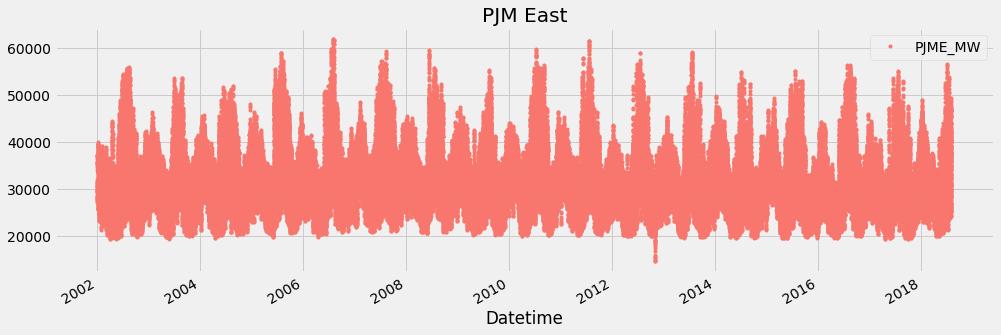

In [3]:
color_pal = ['#F8766D', '#D39200', '#93AA00', '#00BA38', '#00C19F', '#00B9E3', '#619CFF', '#DB72FB']
_ = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

# Train/Test Split

In [4]:
# 2015.01.01 이전 데이터는 training set, 이후 데이터는 test set
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

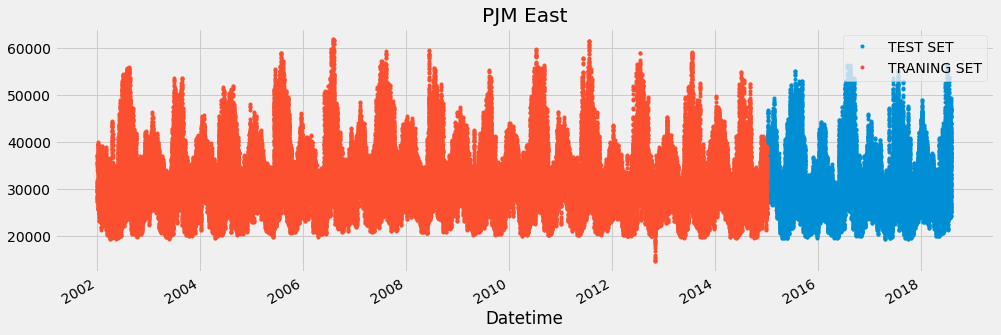

In [5]:
_ = pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRANING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')

# Create Time Series Features

In [6]:
# datetime index로부터 시계열 특징 만들기

def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.week
    
    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year',
           'dayofyear', 'dayofmonth', 'weekofyear']]
    
    if label:
        y = df[label]
        return X, y
    return X

In [7]:
X_train, y_train = create_features(pjme_train, label='PJME_MW')
X_test, y_test = create_features(pjme_test, label='PJME_MW')

/var/folders/h4/qkygjbx150l41hr_cmr5wpt80000gn/T/ipykernel_50391/3873451198.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.week


# Create XGBoost Model

In [8]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
       eval_set=[(X_train, y_train), (X_test, y_test)],
       early_stopping_rounds=50,
       verbose=False)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

Feature importances

feature importance는 모델이 예측을 위해 가장 많이 의존하는 feature에 대한
일반적인 아이디어를 얻는 좋은 방법이다.

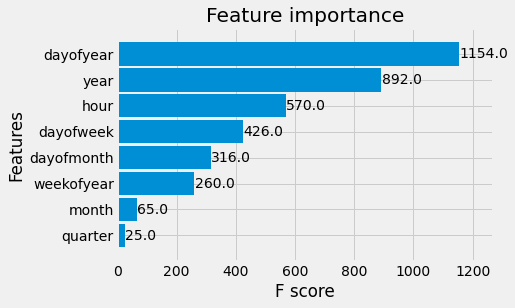

In [9]:
# 각 feature가 분할되는 횟수를 간단히 요약하기

_ = plot_importance(reg, height=0.9)

# Forecast on Test set

In [10]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

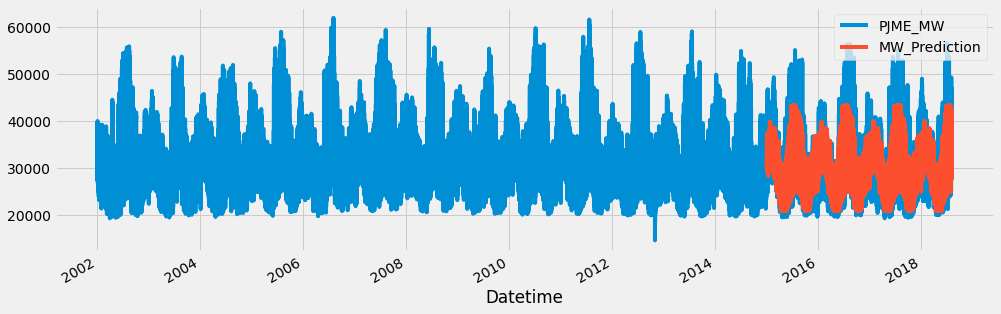

In [11]:
_ = pjme_all[['PJME_MW', 'MW_Prediction']].plot(figsize=(15,5))

# Look at first month of predictions

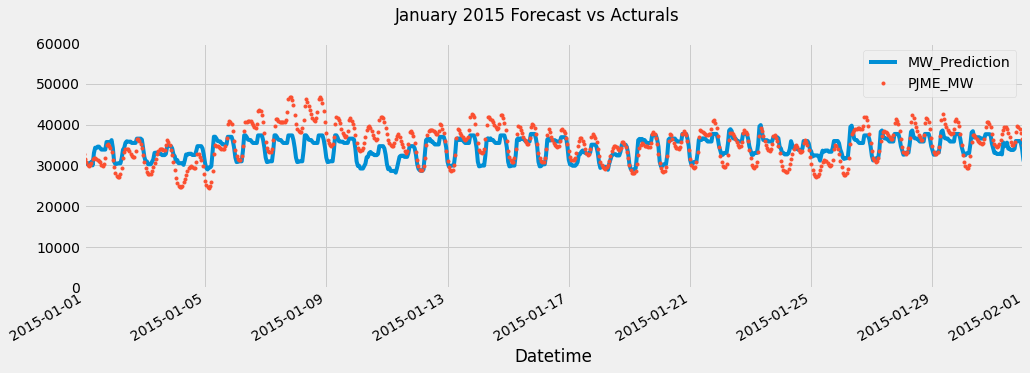

In [12]:
# 실제 값을 사용하여 예측 그림 그리기(1 month)

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction', 'PJME_MW']].plot(ax=ax, style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Acturals')

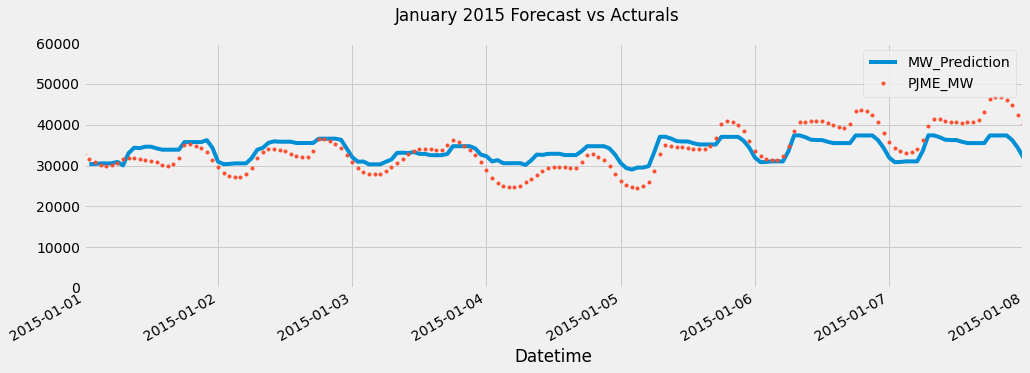

In [13]:
# 실제 값을 사용하여 예측 그림 그리기(1 week)

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction', 'PJME_MW']].plot(ax=ax, style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Acturals')

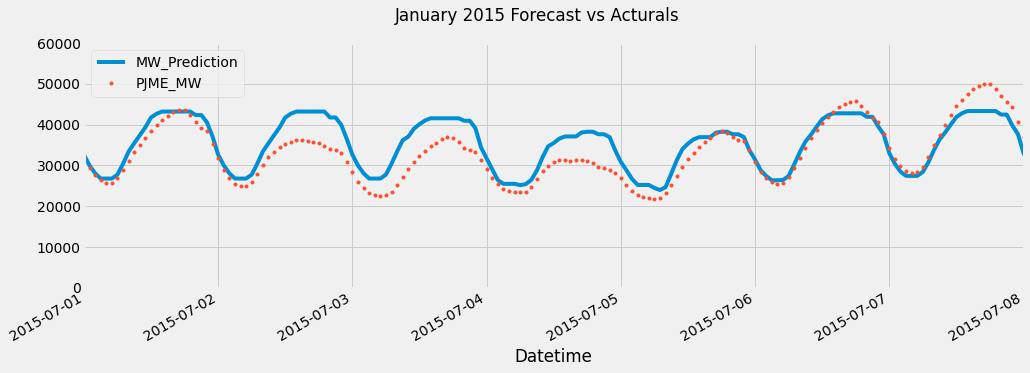

In [14]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction', 'PJME_MW']].plot(ax=ax, style=['-','.'])
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Acturals')

# Error Metrics On Test Set

In [15]:
# MSE

mean_squared_error(y_true=pjme_test['PJME_MW'],
                  y_pred=pjme_test['MW_Prediction'])

13960913.30565261

In [16]:
# MAE

mean_absolute_error(y_true=pjme_test['PJME_MW'],
                  y_pred=pjme_test['MW_Prediction'])

2757.2169004982866

In [17]:
# MAPE

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                  y_pred=pjme_test['MW_Prediction'])

8.510847348494002

# Look at Worst and Best Predicted Days

In [18]:
pjme_test['error'] = pjme_test['PJME_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
error_by_day = pjme_test.groupby(['year', 'month', 'dayofmonth']) \
    .mean()[['PJME_MW', 'MW_Prediction', 'error', 'abs_error']]

In [19]:
# 실제 값보다 크게 예측한 순서대로 보자
error_by_day.sort_values('error', ascending=True).head(10)

# 이 날들은 어떤 의미를 가질까? - 예) 7월 4일은 미국의 독립기념일

PJME_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2016 7     4           28399.958333   36429.839844 -8029.882894  8029.882894
2017 2     24          26445.083333   34425.839844 -7980.756429  7980.756429
           25          24344.458333   31702.664062 -7358.206299  7358.206299
     9     4           26552.416667   33609.351562 -7056.935954  7056.935954
     2     20          27070.583333   33860.238281 -6789.655355  6789.655355
     9     1           27280.500000   33966.476562 -6685.977132  6685.977132
     2     19          24555.500000   31178.527344 -6623.027913  6623.027913
2018 2     21          27572.500000   34057.515625 -6485.015869  6485.015869
2017 3     1           27574.125000   34057.515625 -6483.390869  6483.390869
     2     23          27663.416667   34141.667969 -6478.251872  6478.251872

In [20]:
# 에러가 큰 순서대로 보자
error_by_day.sort_values('abs_error', ascending=False).head(10)

PJME_MW  MW_Prediction         error     abs_error
year month dayofmonth                                                         
2016 8     13          45185.833333   31390.199219  13795.634766  13795.634766
           14          44427.333333   31185.371094  13241.961751  13241.961751
     9     10          40996.166667   27985.250000  13010.917562  13010.917562
           9           43836.958333   32078.492188  11758.466064  11758.466064
     8     12          45724.708333   34440.406250  11284.303223  11284.303223
2018 1     6           43565.750000   32572.080078  10993.670003  10993.670003
2015 2     20          44694.041667   33874.218750  10819.821045  10819.821045
2017 5     19          38032.583333   27777.609375  10254.974935  10254.974935
2015 2     16          43949.500000   33860.238281  10089.261312  10089.261312
     9     9           42266.875000   32276.361328   9990.514160   9990.514160

In [21]:
# 에러가 작은 순서대로 보자
error_by_day.sort_values('abs_error', ascending=True).head(10)

PJME_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2018 5     13          24001.500000   24218.675781 -217.174967  338.625000
2016 4     4           28944.125000   28569.861328  374.264323  429.709147
     9     28          27910.833333   28260.042969 -349.209961  479.797038
2015 10    3           25534.875000   25807.496094 -272.620850  485.690348
     9     22          28185.875000   28314.941406 -129.067383  496.139974
     4     20          27369.000000   27608.917969 -239.918376  503.891357
2018 5     17          28035.208333   28513.269531 -478.060872  515.793783
2016 10    2           24659.083333   25016.308594 -357.224284  515.855794
2015 9     21          27988.041667   28057.207031  -69.165365  517.167806
2017 5     13          24752.333333   24626.263672  126.069092  531.713135

# Plotting some worst/best predicted days

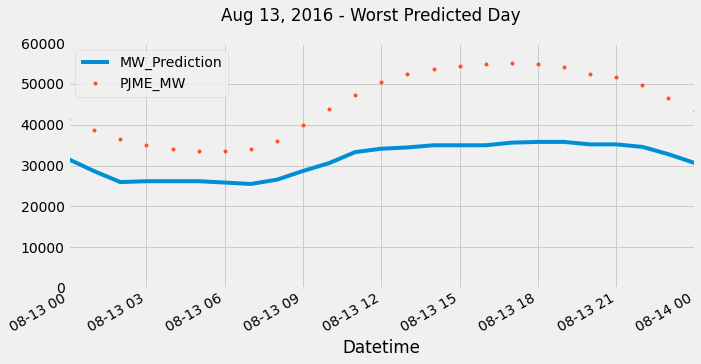

In [22]:
# 에러 제일 큰 날
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction', 'PJME_MW']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

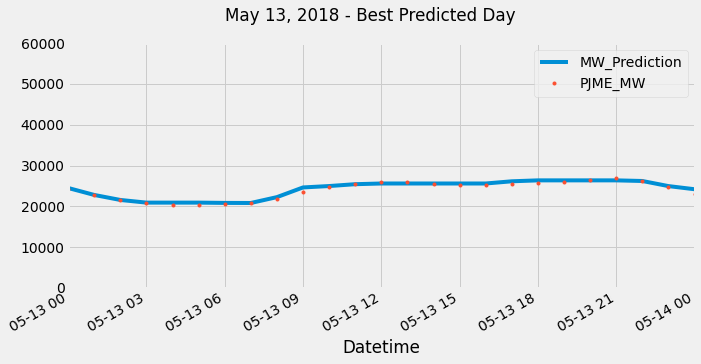

In [23]:
# 에러 제일 작은 날
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction', 'PJME_MW']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='05-13-2018', upper='05-14-2018')
plot = plt.suptitle('May 13, 2018 - Best Predicted Day')